<a href="https://colab.research.google.com/github/chanjaga/Power-Analysis-Attack/blob/main/%E7%B0%A1%E6%98%93%E7%89%88%E3%80%80%E7%9B%B8%E9%96%A2%E9%9B%BB%E5%8A%9B%E8%A7%A3%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [423]:
#簡易版　相関電力解析
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [424]:
#平文
plaintext = [list(i) for i in itertools.product([0, 1], repeat=8)]

#8bit予測鍵の生成
pre_round_key = [list(i) for i in itertools.product([0, 1], repeat=8)]

#トレース観測回数
obs_trace_times = 75000

In [425]:
#リーケージモデル
def leakage_model(pre_round_key,plaintext):
  leakage = [[0]*2**8]*2**8
  for i in range(2**8):
    for j in range(2**8):
      leakage[i][j] = distance.hamming(pre_round_key[i],plaintext[j]) + j*0.01 
  return leakage

In [426]:
#リーケージモデルに基づいた予測トレース（リーケージ）の生成
pre_trace = leakage_model(plaintext,pre_round_key)

In [427]:
#相関電力解析
def cpa(pre_trace,obs_trace):
  analysis_times = int(obs_trace_times/len(pre_trace[0])) * len(pre_trace[0])

  #解析
  correlation = [0]*analysis_times
  result_correlation = []
  for i in range(analysis_times):
    if len(obs_trace[i:i+256]) == 256:
      correlation[i] = np.corrcoef(pre_trace[0],obs_trace[i:i+256])
      #相関係数の取得
      result_correlation.append(correlation[i][1][0])
      #print(f"{i}回目:{result_correlation[i]}")

  #解析毎の相関係数のプロット
  plt.plot(result_correlation)
  plt.show()

  #相関係数を用いたラウンド鍵の特定
  round_key_index = result_correlation.index(max(result_correlation)) % 256
  print(f"ラウンド鍵は{pre_round_key[round_key_index]}です")

In [428]:
#観測トレース
obs_trace = []
for i in range(obs_trace_times):
    obs_trace.append(abs(np.random.normal())) #ダミートレース

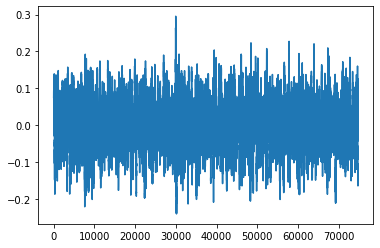

ラウンド鍵は[0, 0, 0, 1, 0, 1, 1, 1]です


In [429]:
#解析実行
cpa(pre_trace,obs_trace)